In [1]:
import torch
import os
import matplotlib.pyplot as plt
from models.dense_baseline import get_baseline
from models.moe_model import MoEModel
from train import train_baseline, train_moe
from utils.data_loader import get_dataloaders
from utils.visualization import (
    HistoryLogger, 
    plot_multimodel_learning_curves, 
    plot_expert_utilization,
    plot_expert_utilization_histogram,
    plot_expert_counts_evolution,
    plot_expert_loss_history, 
    plot_expert_heatmap_from_history,
    compare_params_vs_performance,
    count_total_params,
    count_active_params_moe
)

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data
batch_size = 128
train_loader, val_loader, test_loader, num_classes, img_size = get_dataloaders(batch_size=batch_size)

# Global Settings
DEFAULT_EPOCHS = 5
SAVE_DIR = './experiment_results'
os.makedirs(SAVE_DIR, exist_ok=True)

/home/arthur/miniconda3/envs/ML/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Using device: cuda
Loaded CIFAR-10: 45000 train, 5000 val, 10000 test images.


# 1. Train Models

## 1.1 Dense Baselines
We train three baseline models to establish performance benchmarks relative to parameter count and FLOPs.
*   **Baseline (x1.0):** Matches the parameter count of a single expert.
*   **Baseline (x2.0):** Intermediate capacity model.
*   **Baseline (x3.0):** High capacity model.

In [13]:
baseline_models = {}
baseline_histories = {}

# Define configs
baseline_configs = [
    {'width': 1.0, 'epochs': DEFAULT_EPOCHS*2},
    {'width': 2.0, 'epochs': DEFAULT_EPOCHS*2},
    {'width': 3.0, 'epochs': DEFAULT_EPOCHS*3}
]

for cfg in baseline_configs:
    w = cfg['width']
    epochs = cfg.get('epochs', DEFAULT_EPOCHS)
    
    print(f"\n=== Training Baseline (Width x{w}, Epochs={epochs}) ===")
    model = get_baseline(input_shape=img_size, num_classes=num_classes, width_multiplier=w).to(device)
    
    save_path = os.path.join(SAVE_DIR, f'baseline_w{w}.pth')
    history_path = save_path.replace('.pth', '_history.json')

    # Check if model already exists
    if os.path.exists(save_path) and os.path.exists(history_path):
        print(f"Skipping training, loading model from {save_path}...")
        model.load_state_dict(torch.load(save_path, map_location=device))
    else:
        # Train
        train_baseline(model, train_loader, val_loader, test_loader, epochs, device, save_path)
    
    # Store for analysis
    baseline_models[f'Baseline_x{w}'] = model
    baseline_histories[f'Baseline_x{w}'] = HistoryLogger.load(history_path)


=== Training Baseline (Width x1.0, Epochs=10) ===
Skipping training, loading model from ./experiment_results/baseline_w1.0.pth...

=== Training Baseline (Width x2.0, Epochs=10) ===
Skipping training, loading model from ./experiment_results/baseline_w2.0.pth...

=== Training Baseline (Width x3.0, Epochs=15) ===
Skipping training, loading model from ./experiment_results/baseline_w3.0.pth...


## 1.2 MoE Models
We explore various configurations by adjusting `top_k`, `num_experts`, `aux_weight` (load balancing regularization), and `epochs`. Extended training durations are applied to MoE models to accommodate their larger capacity and distributed training dynamics.

*   **MoE 4 Exp, Top-1, Aux 0.0:** Control group (No load balancing).
*   **MoE 4 Exp, Top-1, Aux 3.0:** Standard configuration with load balancing.
*   **MoE 4 Exp, Top-2, Aux 3.0:** Sparse routing to multiple experts.
*   **MoE 4 Exp, Top-2, Aux 6.0:** High regularization regime.
*   **MoE 4 Exp, Top-3, Aux 3.0:** Dense-like routing (utilizing most experts).
*   **MoE 8 Exp, Top-2, Aux 8.0:** Scaled-up expert capacity.

In [14]:
moe_configs = [
    {'name': 'MoE_4E_Top1_Aux0.0', 'experts': 4, 'topk': 1, 'aux': 0.0, 'epochs': DEFAULT_EPOCHS*2},
    {'name': 'MoE_4E_Top1_Aux3.0', 'experts': 4, 'topk': 1, 'aux': 3.0, 'epochs': DEFAULT_EPOCHS*4},
    {'name': 'MoE_4E_Top2_Aux3.0', 'experts': 4, 'topk': 2, 'aux': 3.0, 'epochs': DEFAULT_EPOCHS*4},
    {'name': 'MoE_4E_Top2_Aux6.0', 'experts': 4, 'topk': 2, 'aux': 6.0, 'epochs': DEFAULT_EPOCHS*4},
    {'name': 'MoE_4E_Top3_Aux3.0', 'experts': 4, 'topk': 3, 'aux': 6.0, 'epochs': DEFAULT_EPOCHS*4},
    {'name': 'MoE_8E_Top2_Aux10.0', 'experts': 8, 'topk': 2, 'aux': 10.0, 'epochs': DEFAULT_EPOCHS*8},
]

moe_models = {}
moe_histories = {}

for cfg in moe_configs:
    epochs = cfg.get('epochs', DEFAULT_EPOCHS)
    print(f"\n=== Training {cfg['name']} (Epochs={epochs}) ===")
    model = MoEModel(num_experts=cfg['experts'], num_classes=num_classes, 
                     input_channels=img_size[0], top_k=cfg['topk']).to(device)
    
    save_path = os.path.join(SAVE_DIR, f"{cfg['name']}.pth")
    history_path = save_path.replace('.pth', '_history.json')
    
    # Check if model already exists
    if os.path.exists(save_path) and os.path.exists(history_path):
        print(f"Skipping training, loading model from {save_path}...")
        model.load_state_dict(torch.load(save_path, map_location=device))
    else:
        train_moe(model, train_loader, val_loader, test_loader, epochs, device, save_path, aux_weight=cfg['aux'])
    
    moe_models[cfg['name']] = model
    moe_histories[cfg['name']] = HistoryLogger.load(history_path)


=== Training MoE_4E_Top1_Aux0.0 (Epochs=10) ===
Skipping training, loading model from ./experiment_results/MoE_4E_Top1_Aux0.0.pth...

=== Training MoE_4E_Top1_Aux3.0 (Epochs=20) ===
Skipping training, loading model from ./experiment_results/MoE_4E_Top1_Aux3.0.pth...

=== Training MoE_4E_Top2_Aux3.0 (Epochs=20) ===
Skipping training, loading model from ./experiment_results/MoE_4E_Top2_Aux3.0.pth...

=== Training MoE_4E_Top2_Aux6.0 (Epochs=20) ===
Skipping training, loading model from ./experiment_results/MoE_4E_Top2_Aux6.0.pth...

=== Training MoE_4E_Top3_Aux3.0 (Epochs=20) ===
Skipping training, loading model from ./experiment_results/MoE_4E_Top3_Aux3.0.pth...

=== Training MoE_8E_Top2_Aux10.0 (Epochs=40) ===
Skipping training, loading model from ./experiment_results/MoE_8E_Top2_Aux10.0.pth...


# 2. Global Performance Analysis

## 2.1 Training Dynamics (Accuracy & Loss)

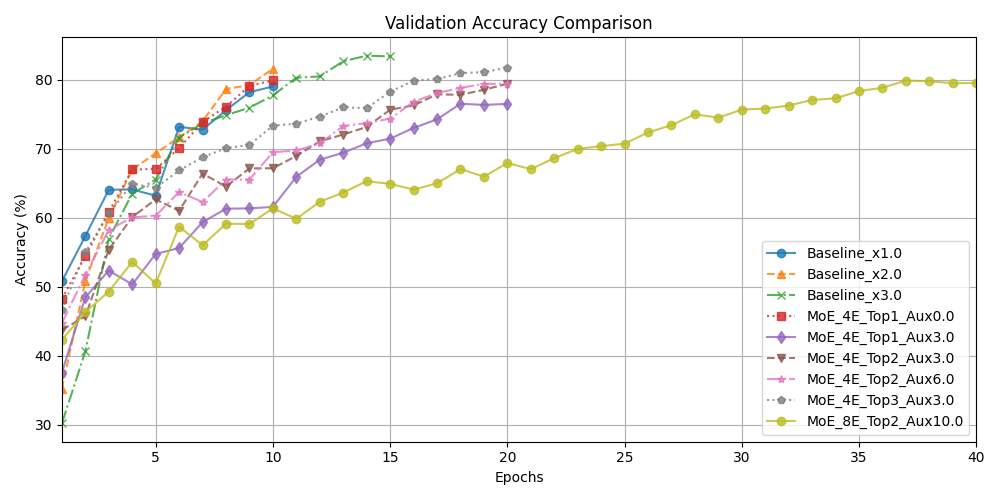

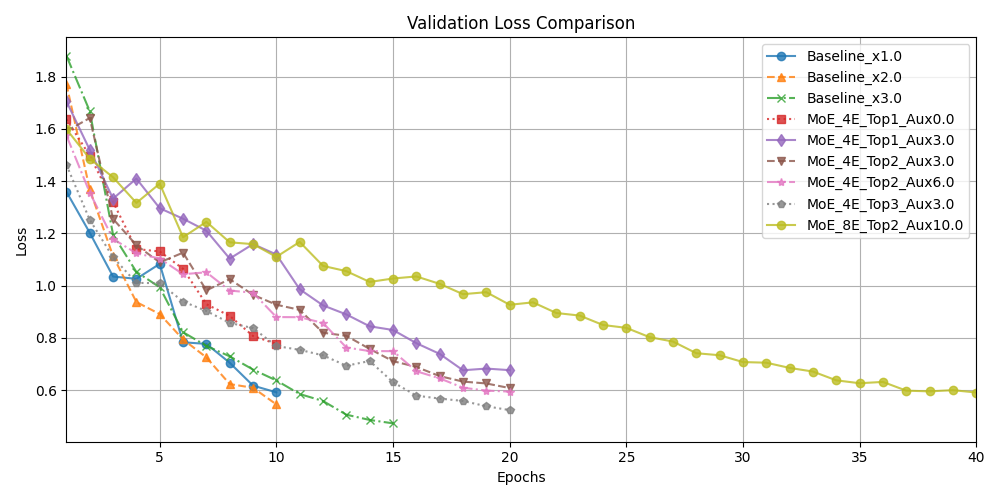

In [15]:
# Combine all histories for plotting
all_histories = {**baseline_histories, **moe_histories}

# Plot multimodel comparison
plot_multimodel_learning_curves(all_histories, SAVE_DIR)

# Display plots inline
from IPython.display import Image, display
display(Image(filename=os.path.join(SAVE_DIR, 'multimodel_comparison_accuracy.png')))
display(Image(filename=os.path.join(SAVE_DIR, 'multimodel_comparison_loss.png')))


### Analysis of Training Dynamics

The learning curves shows expected behavior: **larger models generally require longer convergence times**, but ultimately achieve comparable accuracy (ranging from **75% to 85%**). 
We observe a similar trend in the loss curves, where larger models show a more gradual descent.

This validates that while MoE architectures (being larger in general but less really used nodes) require extended training durations, they are capable of matching or exceeding the performance of dense baselines.

**Note:** It is important to consider that CIFAR-10 is a relatively manageable dataset. While it allows for rapid experimentation, MoE architectures typically demonstrate their full distinct advantages on more complex, large-scale problems.

## 2.2 Efficiency vs. Capacity
*   Accuracy vs. Total Parameters (Storage Cost).
*   Accuracy vs. Active Parameters (Inference Cost/Speed).

=== Accuracy vs Total Parameters (Storage) ===


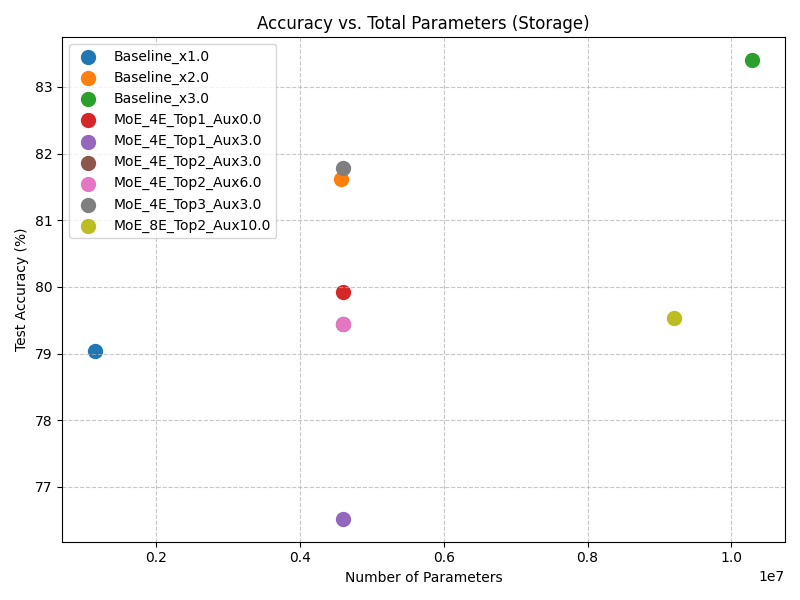


=== Accuracy vs Active Parameters (Inference FLOPs Proxy) ===


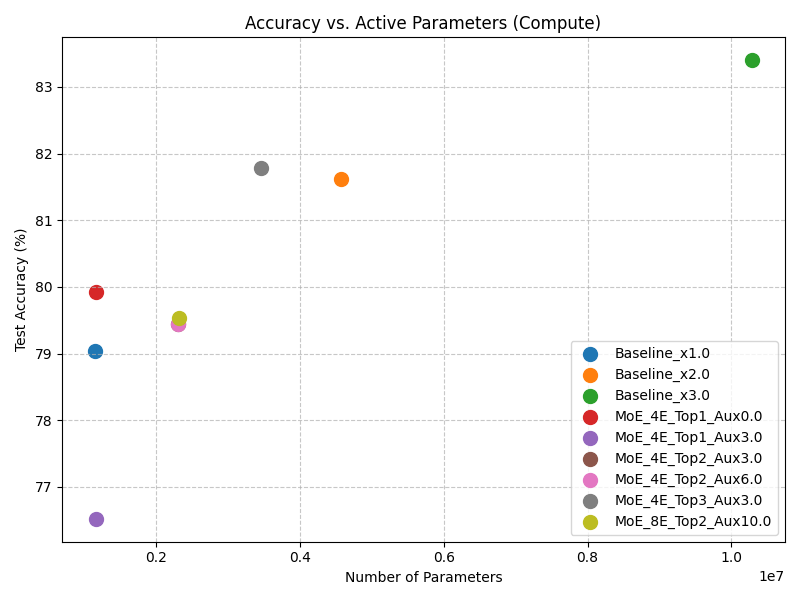

In [16]:
storage_data = [] # Accuracy vs Total Params
compute_data = [] # Accuracy vs Active Params

# Process Baselines
for name, model in baseline_models.items():
    acc = baseline_histories[name].history['val_acc'][-1]
    total_p = count_total_params(model)
    # For dense models, active = total
    storage_data.append({'name': name, 'params': total_p, 'accuracy': acc})
    compute_data.append({'name': name, 'params': total_p, 'accuracy': acc})

# Process MoEs
for name, model in moe_models.items():
    acc = moe_histories[name].history['val_acc'][-1]
    
    total_p = count_total_params(model)
    active_p = count_active_params_moe(model)
    
    storage_data.append({'name': name, 'params': total_p, 'accuracy': acc})
    compute_data.append({'name': name, 'params': active_p, 'accuracy': acc})

# Plot 1: Storage
print("=== Accuracy vs Total Parameters (Storage) ===")
compare_params_vs_performance(storage_data, os.path.join(SAVE_DIR, 'acc_vs_storage.png'), title='Accuracy vs. Total Parameters (Storage)')
display(Image(filename=os.path.join(SAVE_DIR, 'acc_vs_storage.png')))

# Plot 2: Compute
print("\n=== Accuracy vs Active Parameters (Inference FLOPs Proxy) ===")
compare_params_vs_performance(compute_data, os.path.join(SAVE_DIR, 'acc_vs_compute.png'), title='Accuracy vs. Active Parameters (Compute)')
display(Image(filename=os.path.join(SAVE_DIR, 'acc_vs_compute.png')))

### Analysis of Efficiency

This visualization illustrates the core value proposition of MoE architectures.

The first graph demonstrates that our dense baseline models follow a logarithmic performance increase relative to the total number of parameters (which equals active parameters in dense models).

In contrast, the MoE models exhibit significant variance based on hyperparameter configuration:

*   **MoE 4 Exp, Top-1, Aux 0.0:** This model performs similarly to **Baseline_x1.0**, indicating **Expert Collapse**. Without load balancing, the gating network routes to a single dominant expert, effectively reducing the MoE to a small dense model. The slightly worse performances compared to the baseline may be attributed to the gating mechanism.
*   **MoE 4 Exp, Top-1, Aux 3.0:** The introduction of the Auxiliary Loss Coefficient mitigates Expert Collapse. However, with `top_k=1`, the model utilizes the expert distribution badly and limits potential gains.
*   **MoE 4 Exp, Top-2, Aux 3.0:** (Note: Brown and Pink points overlap). By routing to the top-2 experts, we leverage the ensemble property of MoEs. This configuration increases active parameters but results in improved accuracy, effectively utilizing the specialized sub-models.
*   **MoE 4 Exp, Top-2, Aux 6.0:** Increasing the auxiliary loss further provides no additional benefit, suggesting that the `Aux 3.0` setting was sufficient to balance the load. Excessive regularization can potentially constrain the gating network's optimal routing policy.
*   **MoE 4 Exp, Top-3, Aux 3.0:** Routing to 3 out of 4 experts transforms the model into a near-dense architecture. We observe significant improvement, reaching the performance of **Baseline_x2.0** but with fewer active parameters, highlighting the efficiency of sparse activation even in high-utilization regimes.
*   **MoE 8 Exp, Top-2, Aux 8.0:** Scaling to 8 experts on this doesn't give much improvements. The problem complexity is not sufficient to fully exploit a larger number of experts.

# 3. Gating & Expert Analysis

We analyze how experts are utilized and how they learn.
*   **Utilization Histogram:** Did the experts handle an equal share of data?
*   **Counts Evolution:** How many samples per expert over time?
*   **Loss Evolution:** Did experts learn at the same speed?


--- Analyzing MoE_4E_Top1_Aux0.0 ---


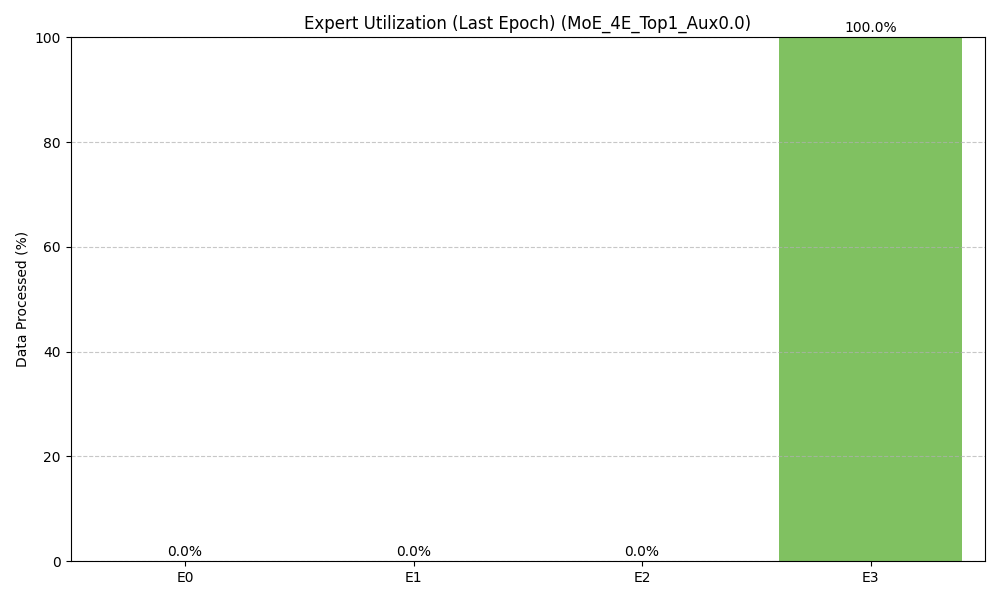

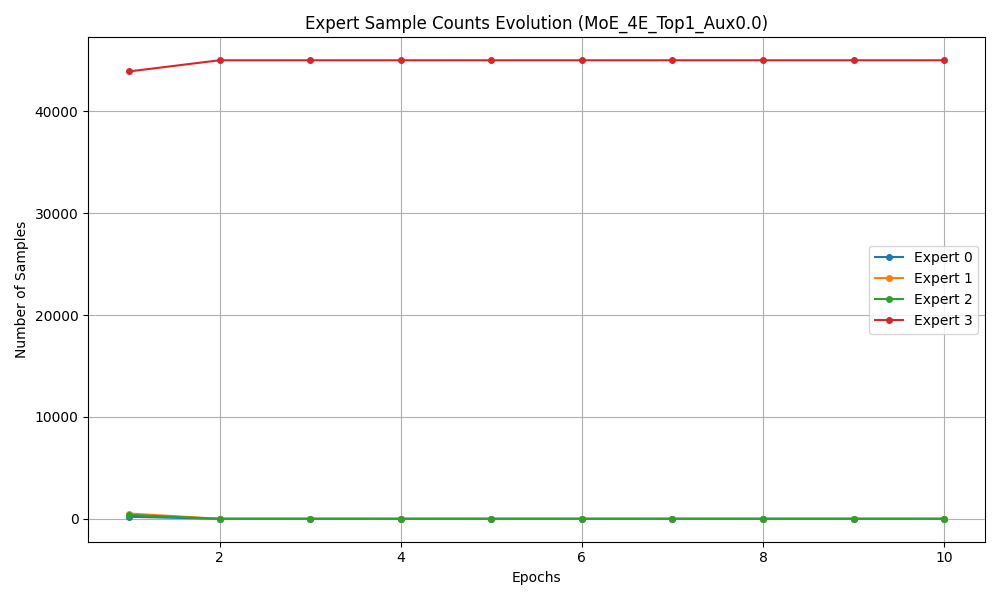

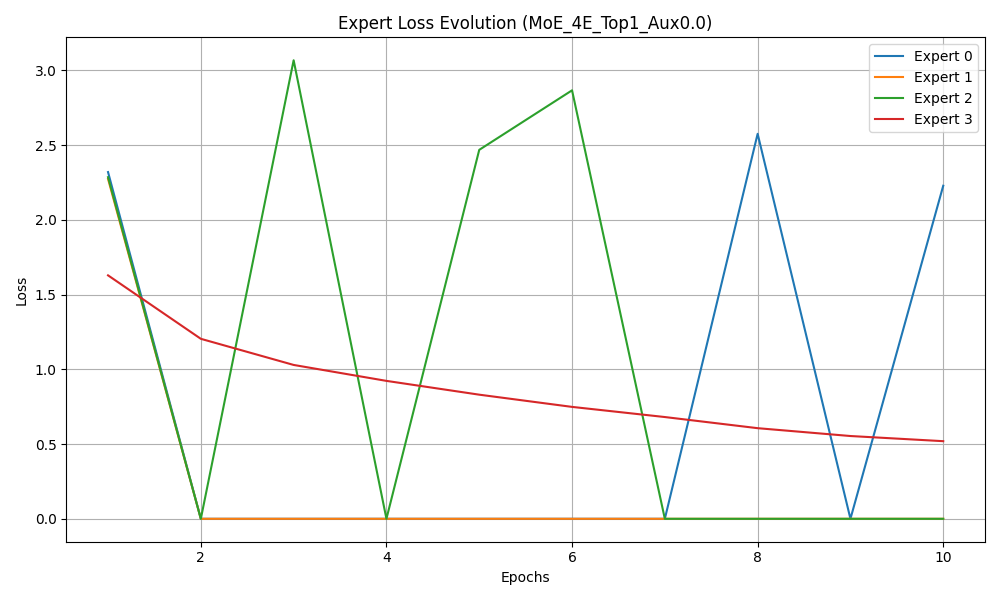


--- Analyzing MoE_4E_Top1_Aux3.0 ---


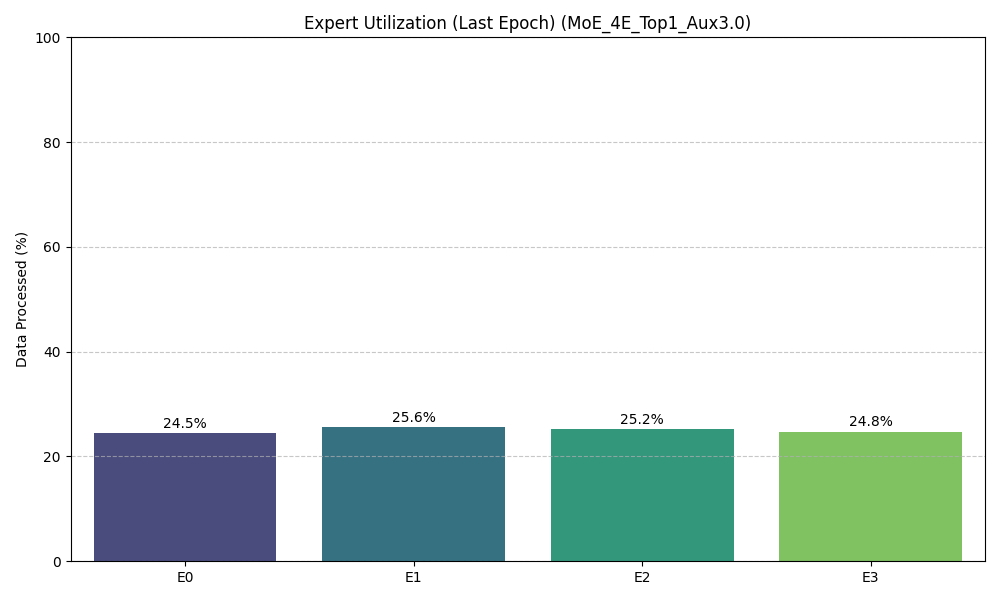

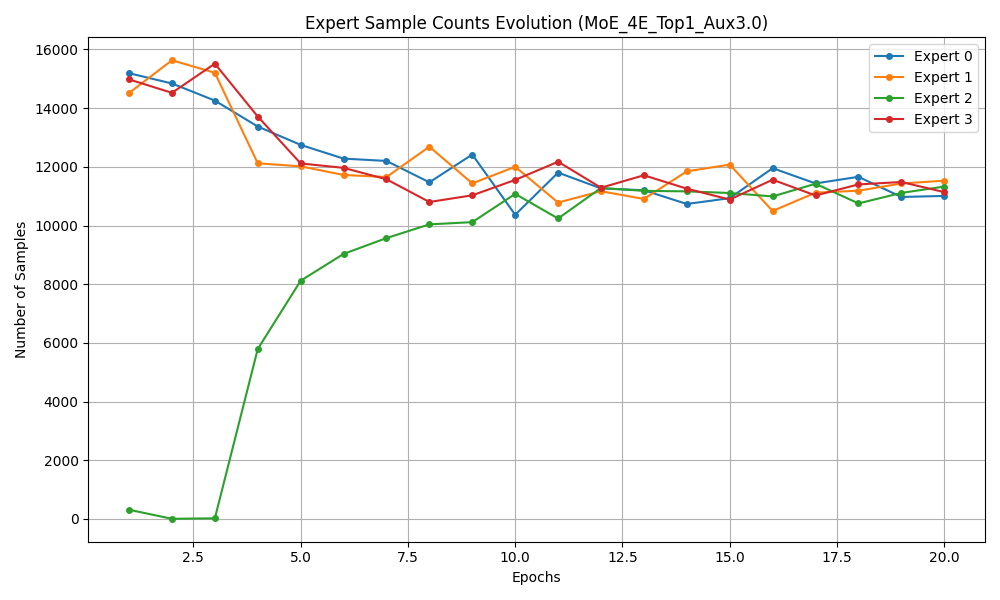

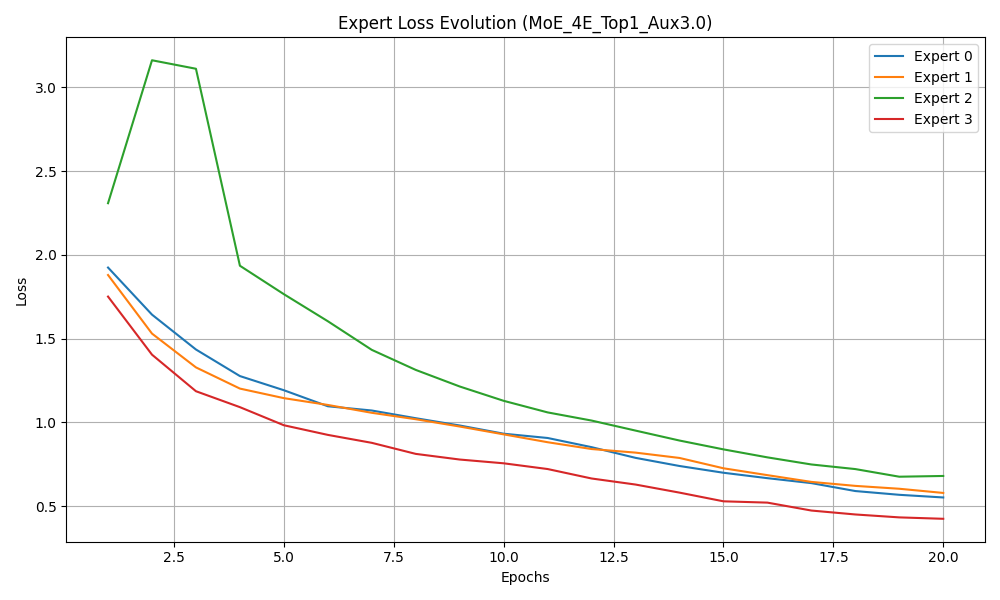


--- Analyzing MoE_4E_Top2_Aux3.0 ---


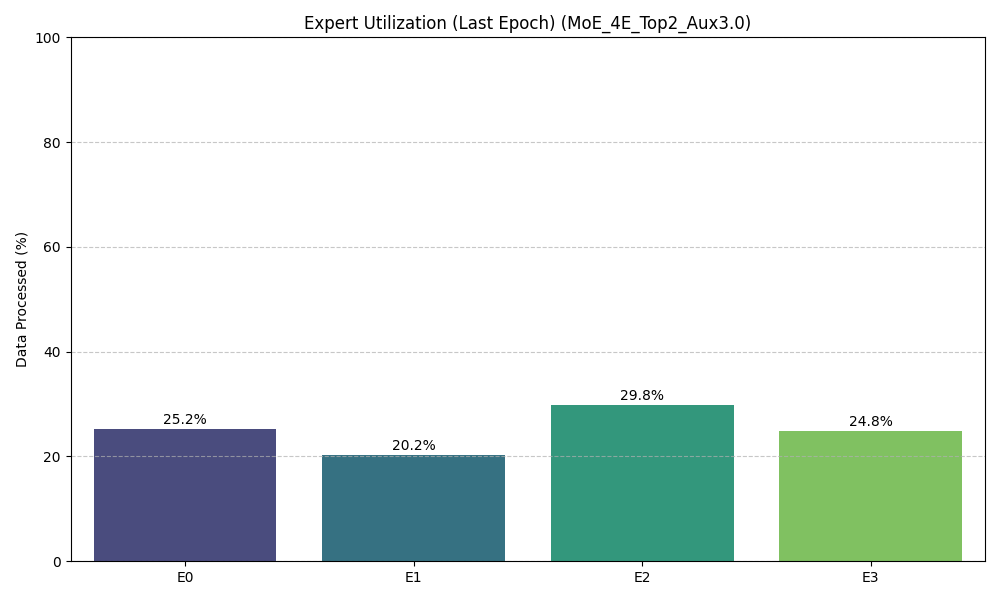

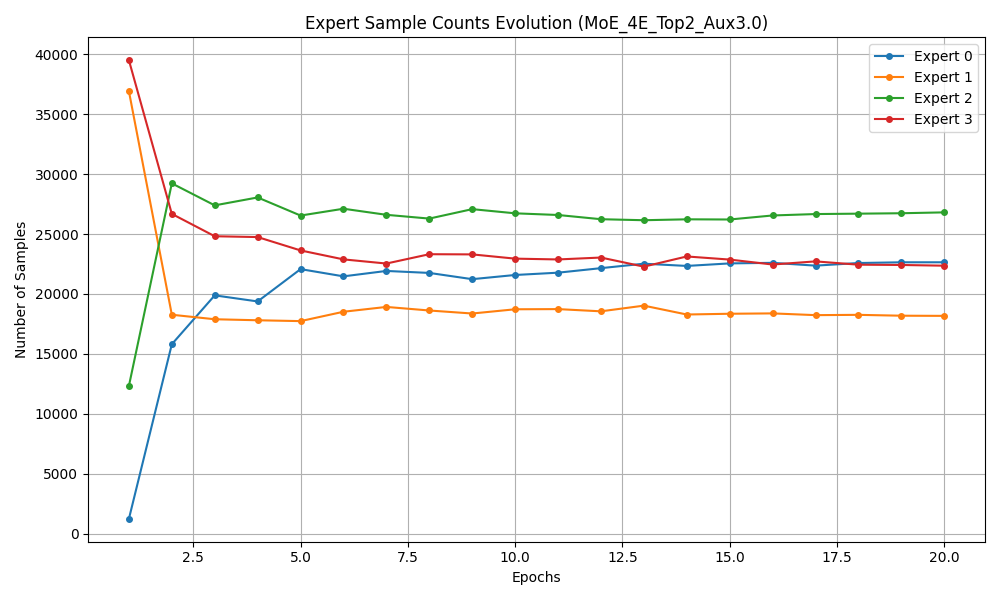

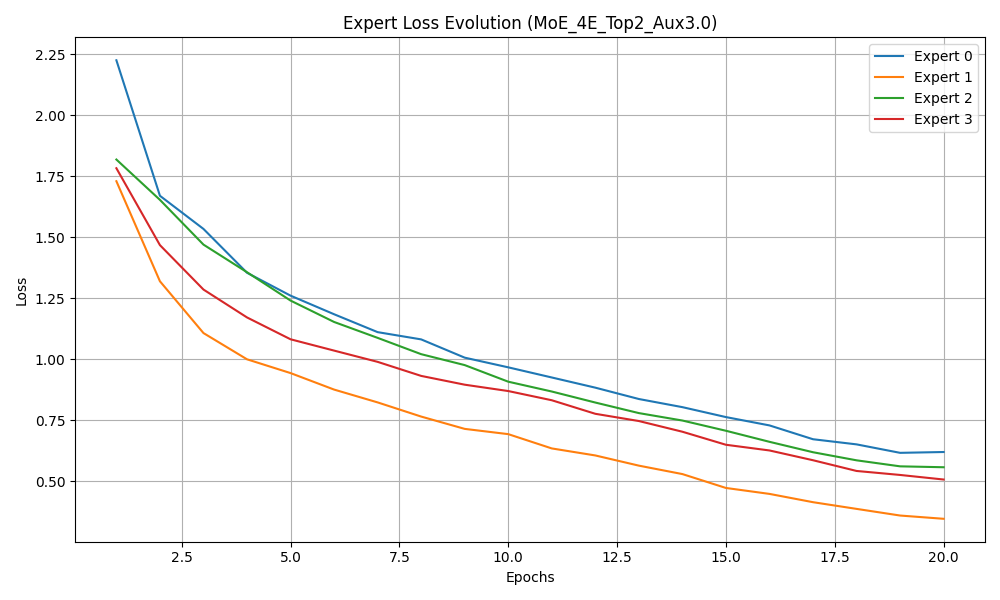


--- Analyzing MoE_4E_Top2_Aux6.0 ---


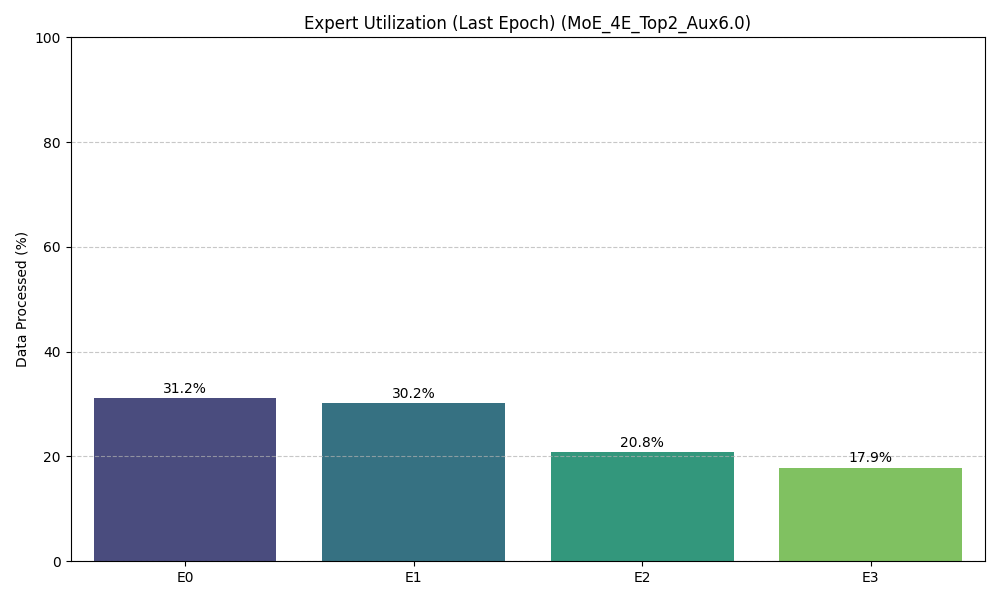

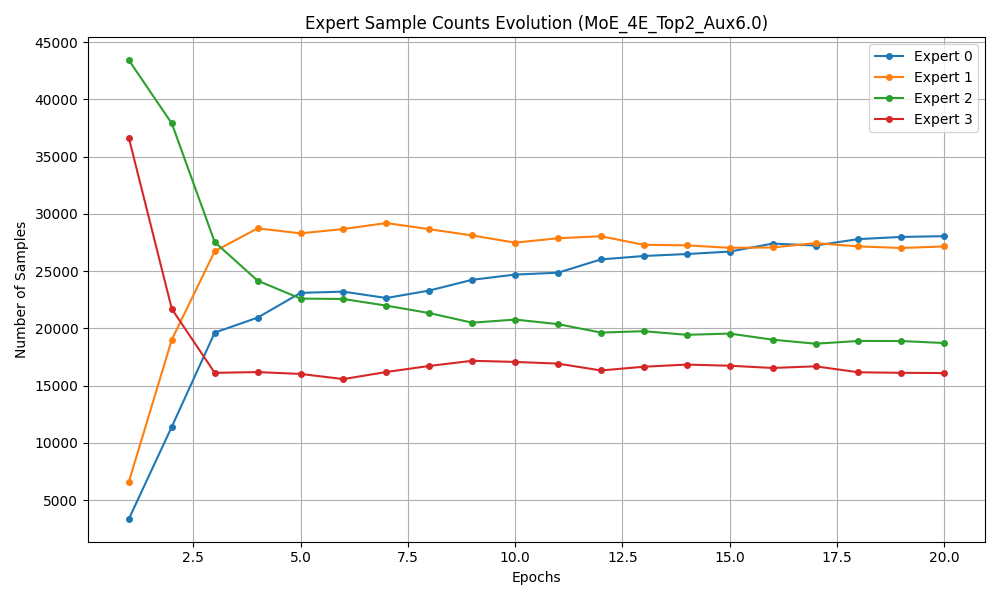

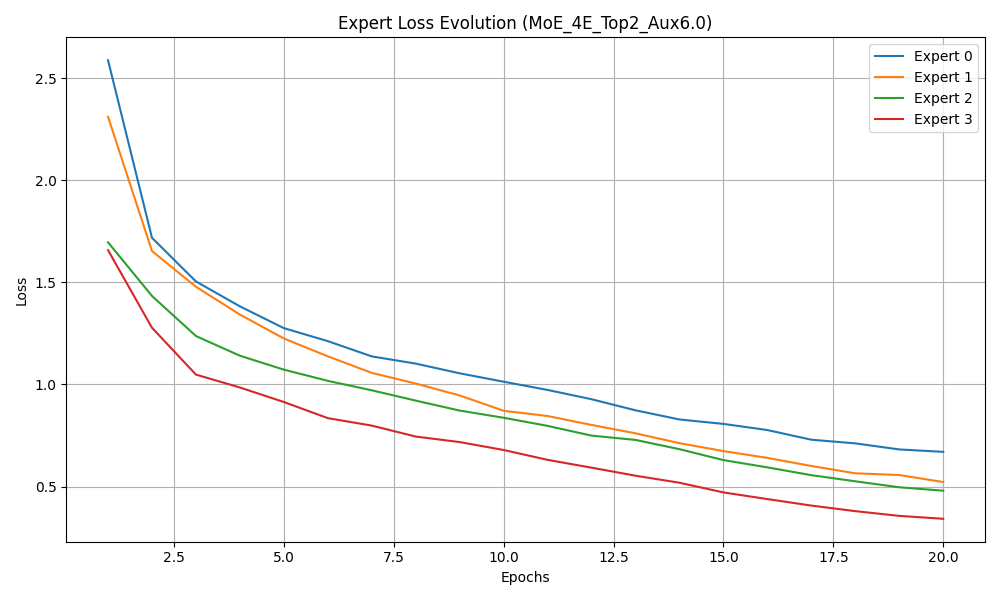


--- Analyzing MoE_4E_Top3_Aux3.0 ---


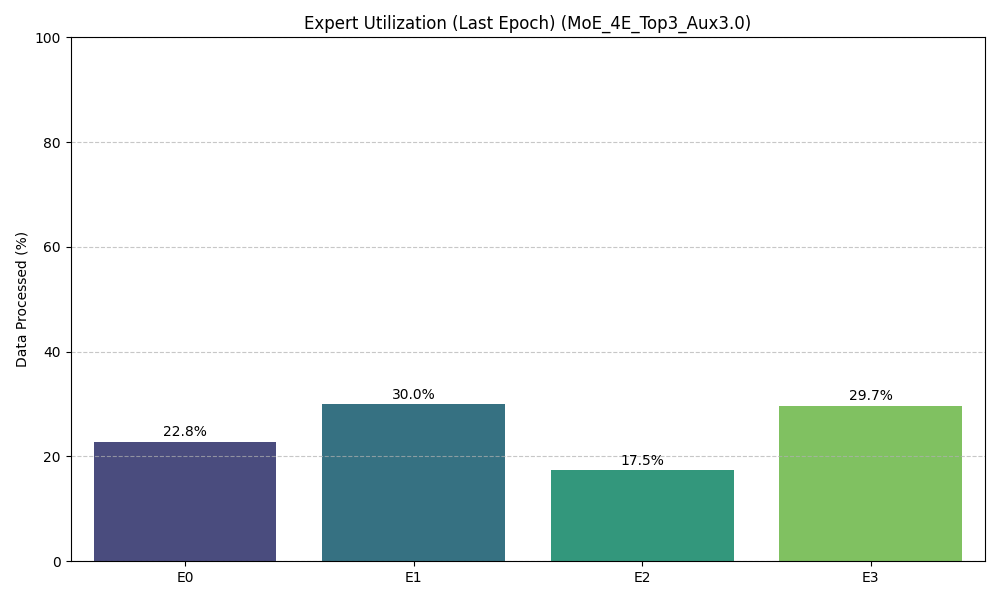

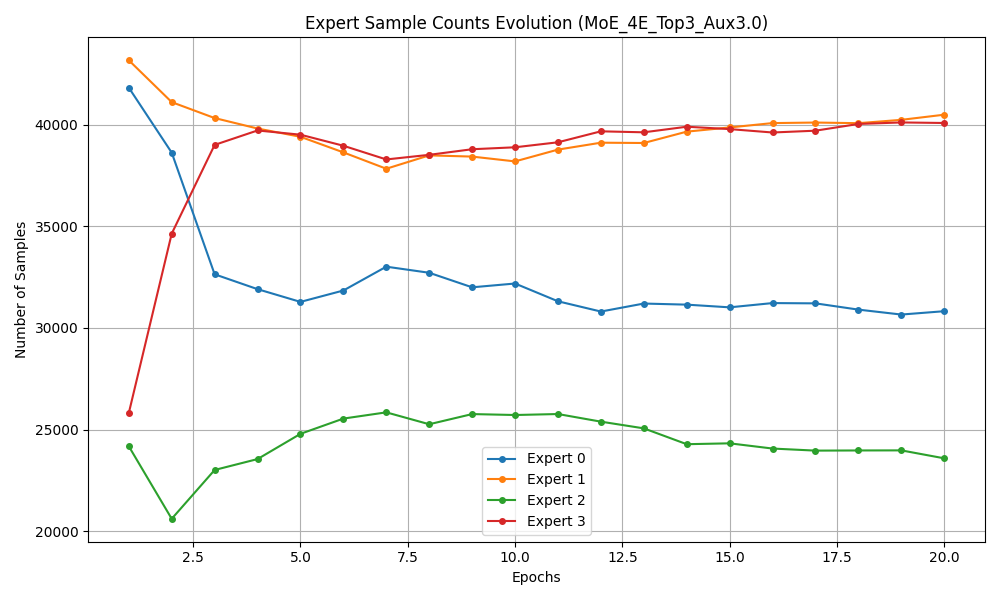

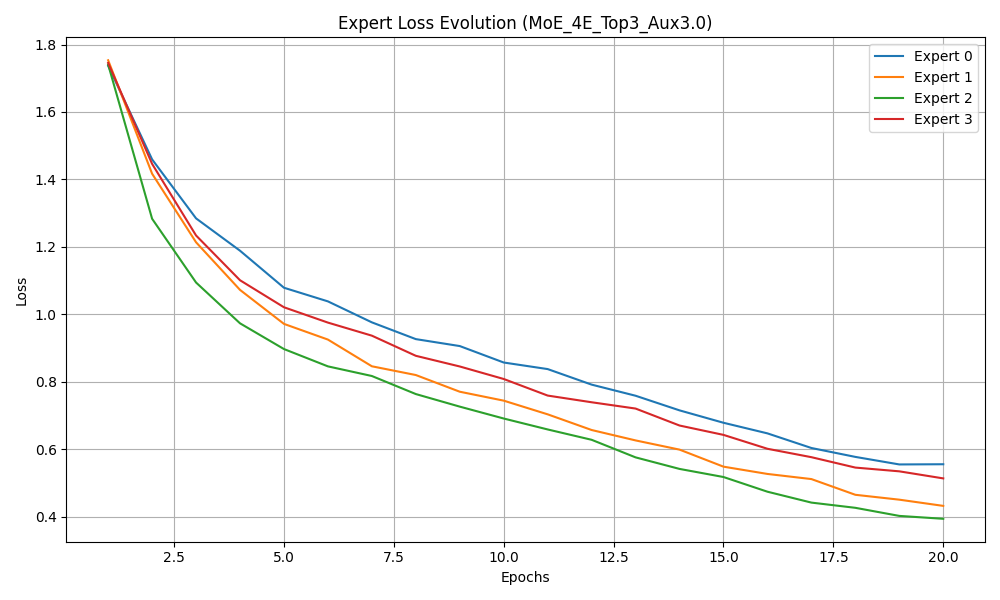


--- Analyzing MoE_8E_Top2_Aux10.0 ---


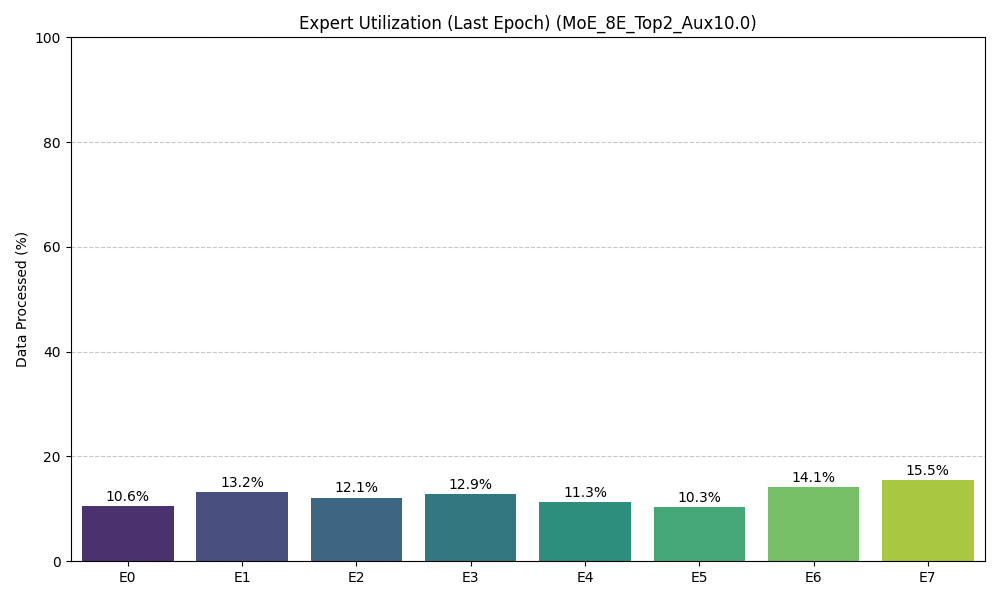

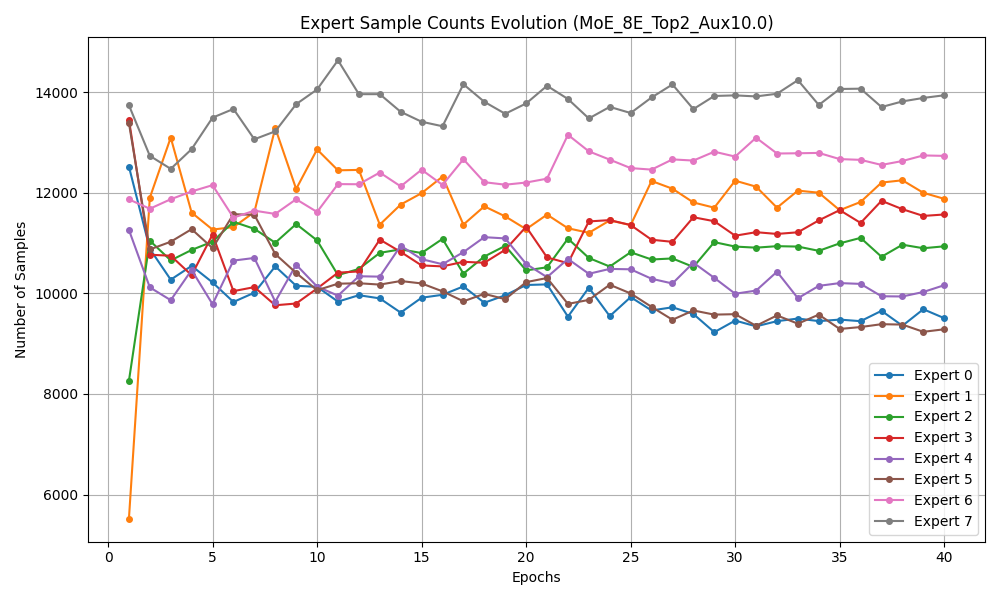

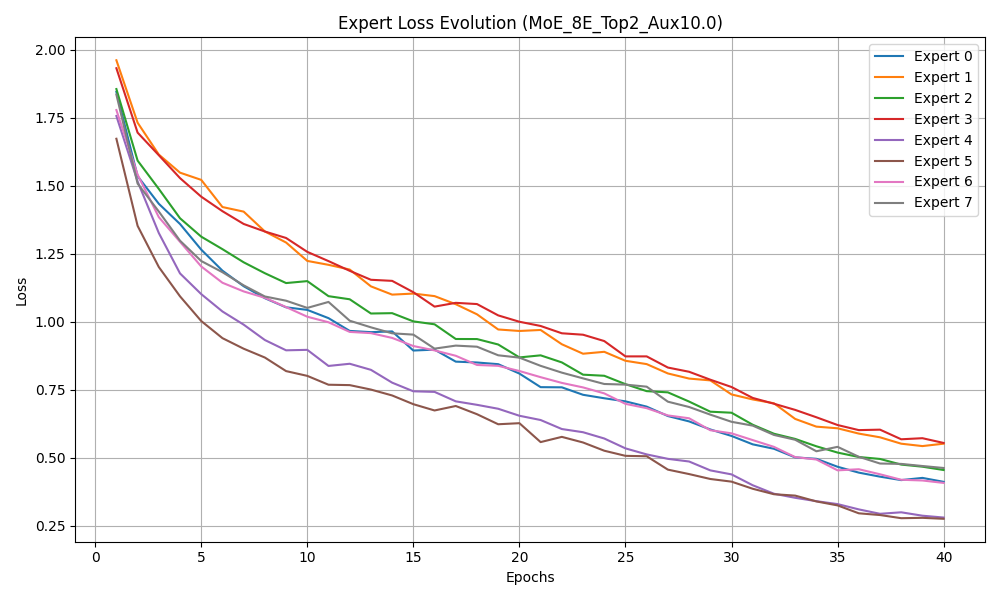

In [17]:
# Analyze each MoE configuration
for name in moe_histories.keys():
    print(f"\n--- Analyzing {name} ---")
    hist = moe_histories[name]
    
    # 1. Expert Usage Histogram (Last Epoch)
    plot_expert_utilization_histogram(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_utilization_histogram{f"({name})".replace(" ", "_").lower()}.png')))
    
    # 1b. Expert Usage Evolution (Stacked Area)
    # plot_expert_utilization(hist, SAVE_DIR) # Generates 'expert_utilization_evolution.png'
    # Rename it to keep unique
    # os.rename(os.path.join(SAVE_DIR, 'expert_utilization_evolution.png'), 
    #           os.path.join(SAVE_DIR, f'expert_utilization_evolution_{name}.png'))
    
    # 2. Expert Counts Evolution (Line Plot)
    plot_expert_counts_evolution(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_counts_evolution{f"({name})".replace(" ", "_").lower()}.png')))

    # 3. Expert Loss Evolution
    plot_expert_loss_history(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_loss_evolution{f"({name})".replace(" ", "_").lower()}.png')))


### Analysis of Expert Utilization

The expert utilization metrics align with what we expected. The histograms and evolution plots indicate that experts are learning equitably and linearly over time, confirming that the auxiliary loss is effectively preventing collapse and ensuring a balanced distribution of data across the available experts.

# 4. Specialization
Do experts specialize in specific classes (e.g., Expert 0 -> Animals, Expert 1 -> Vehicles)?


--- Specialization: MoE_4E_Top1_Aux0.0 ---


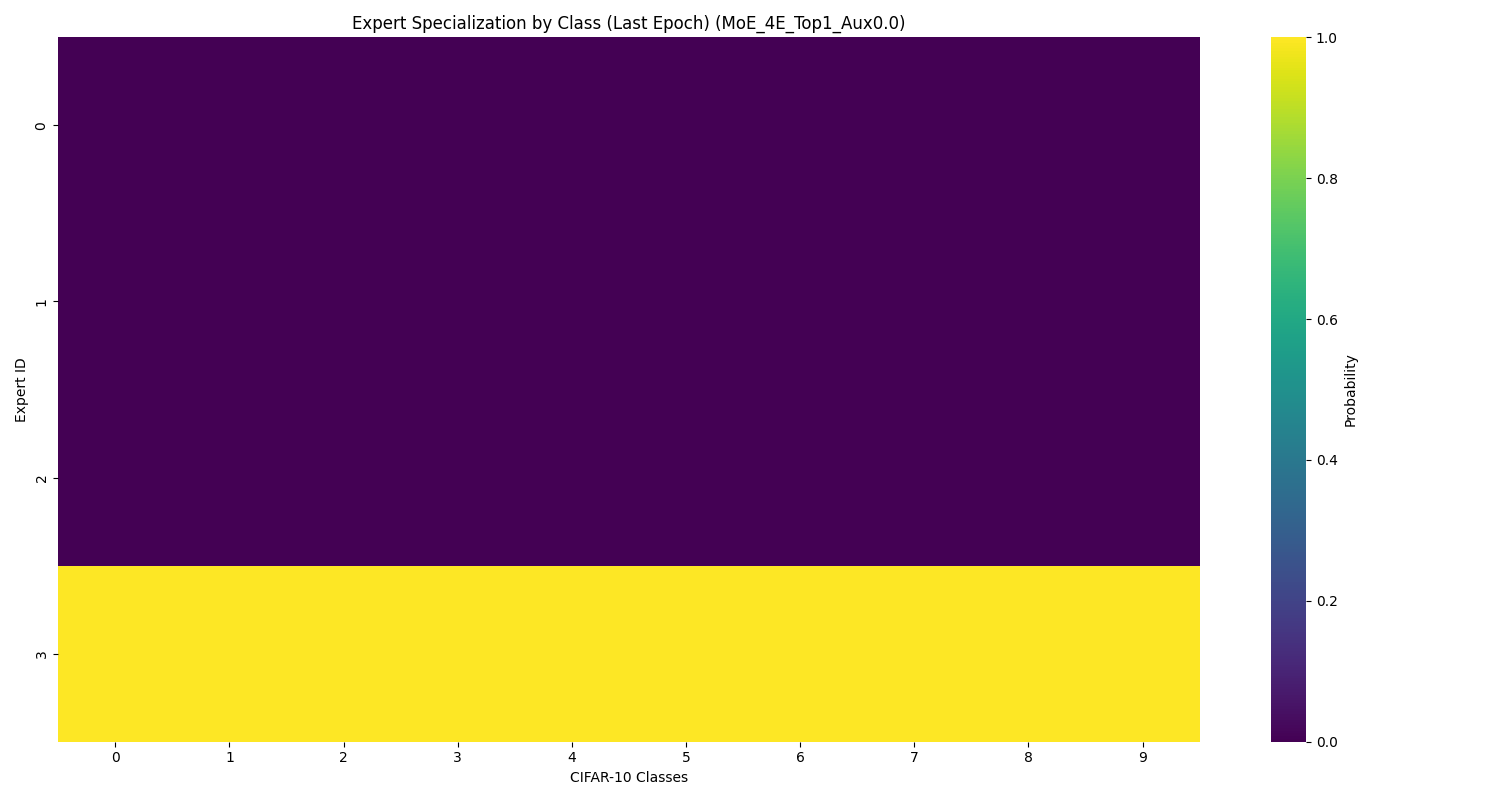


--- Specialization: MoE_4E_Top1_Aux3.0 ---


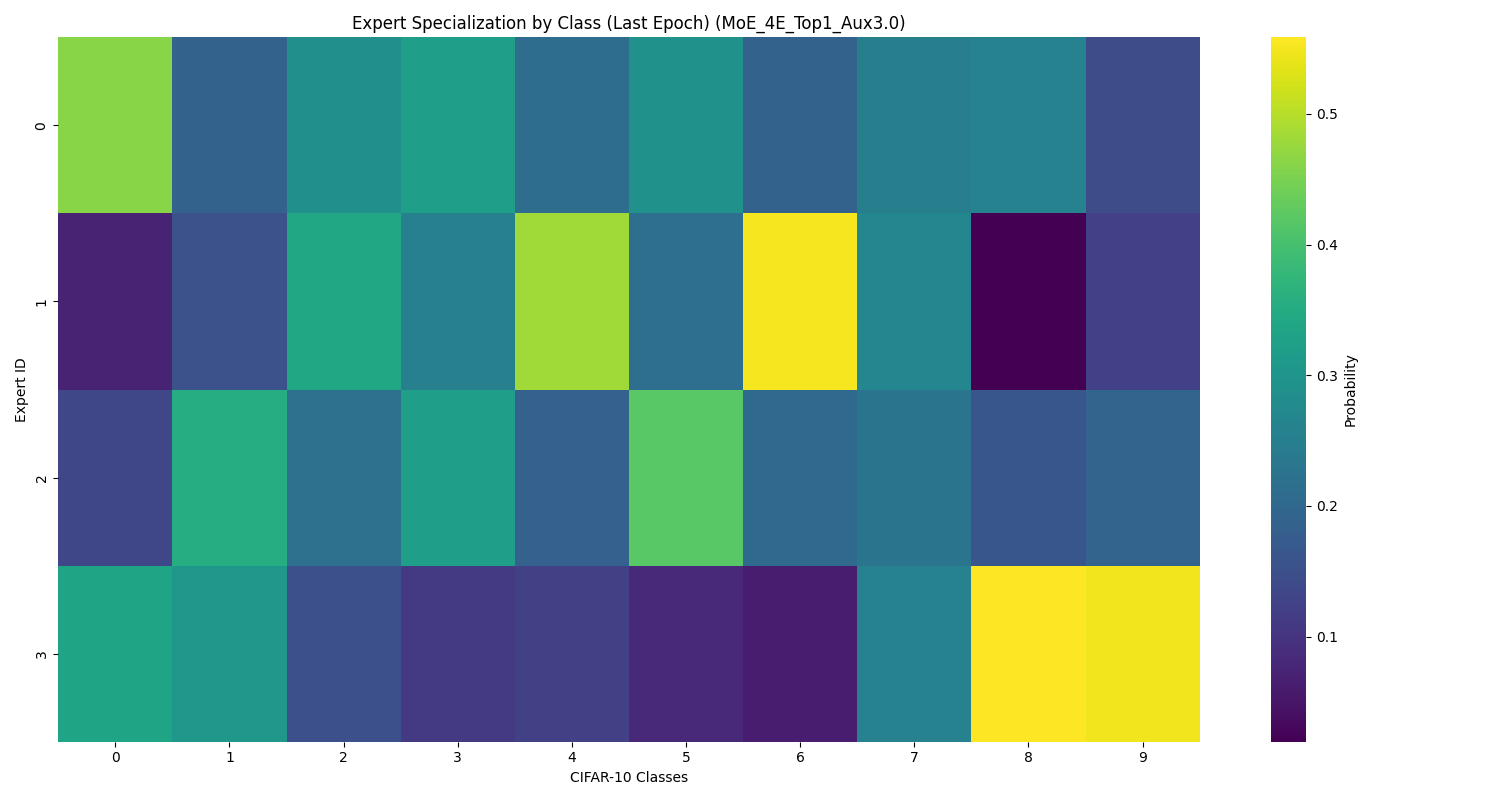


--- Specialization: MoE_4E_Top2_Aux3.0 ---


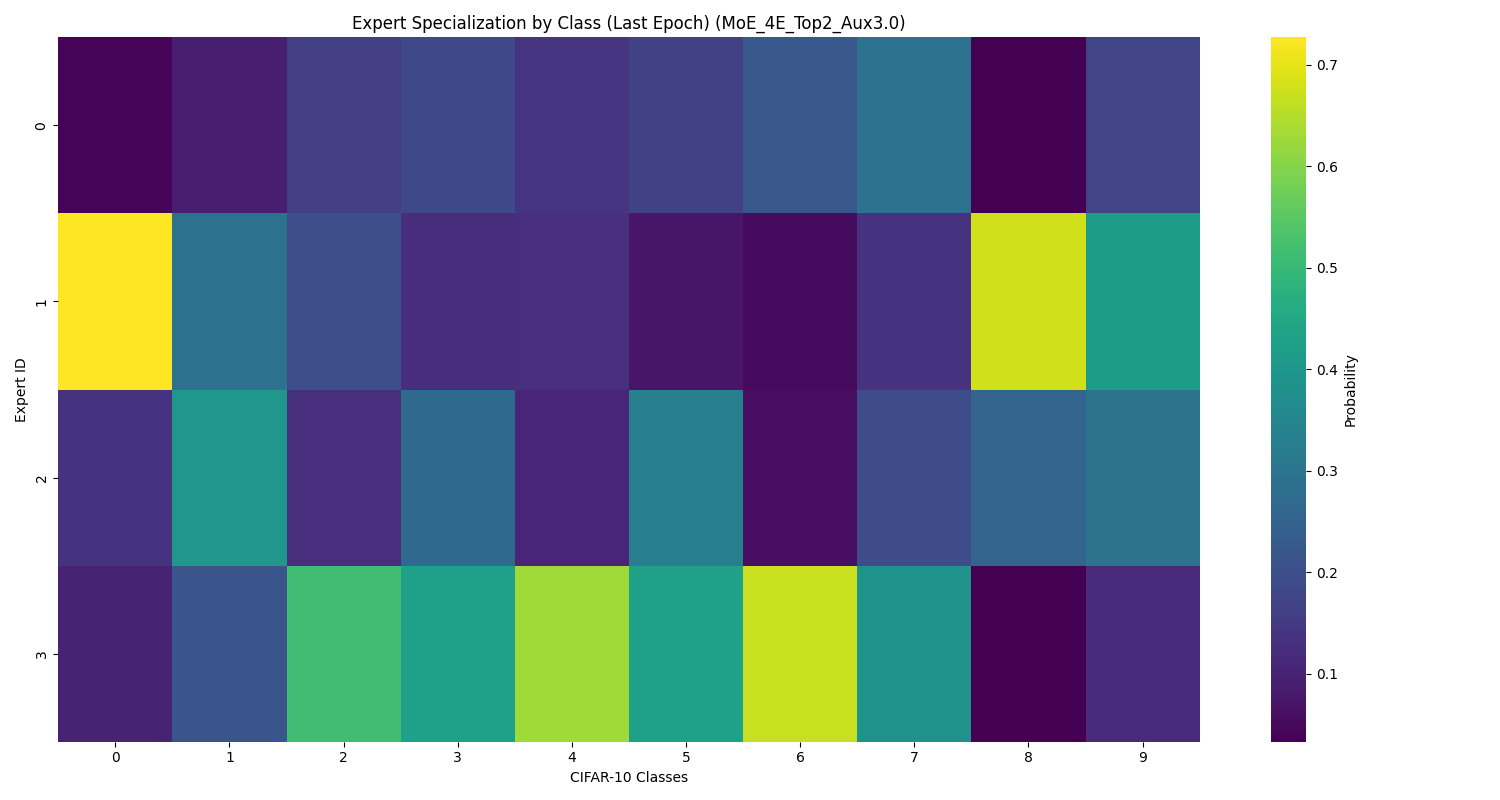


--- Specialization: MoE_4E_Top2_Aux6.0 ---


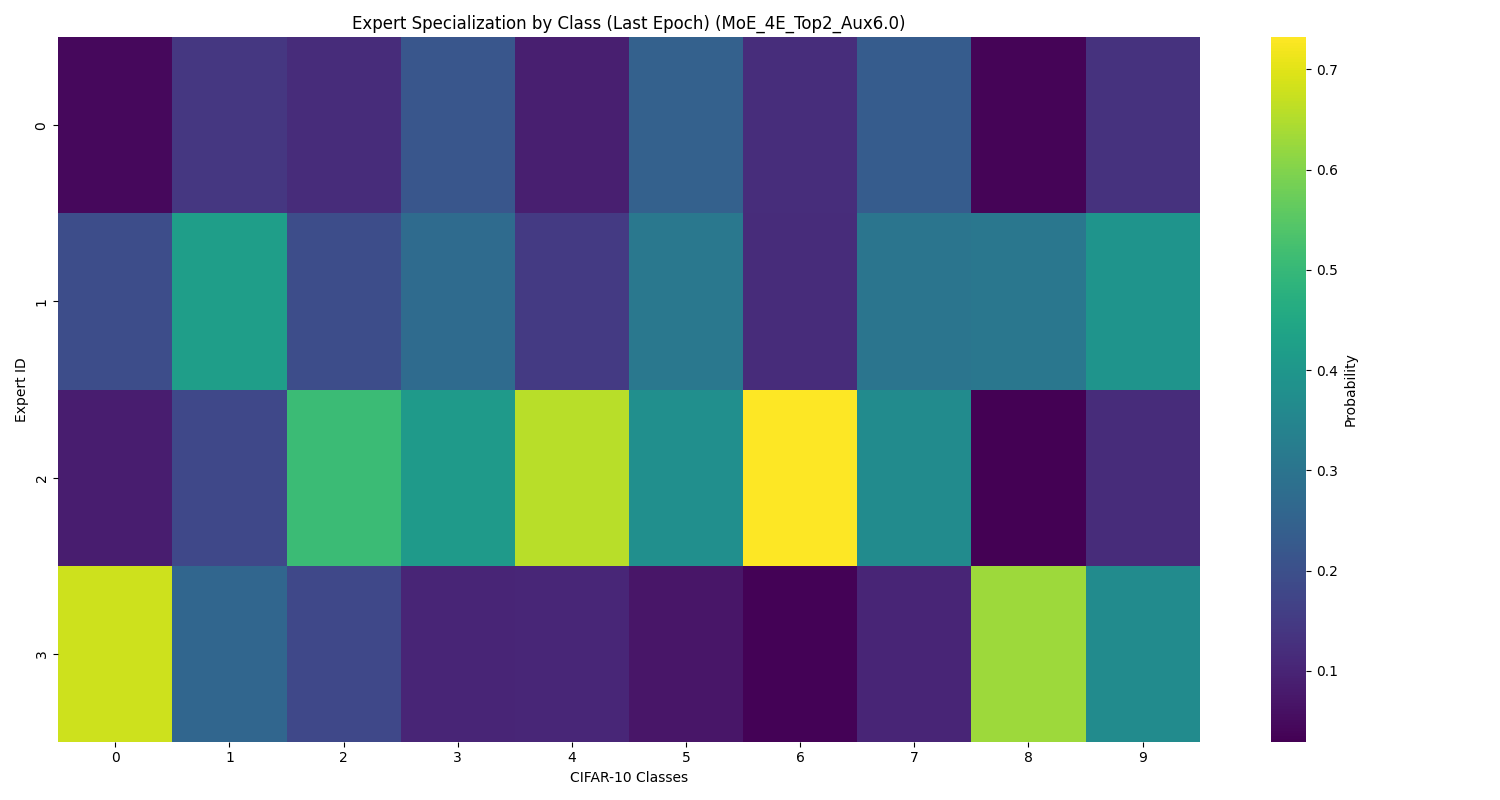


--- Specialization: MoE_4E_Top3_Aux3.0 ---


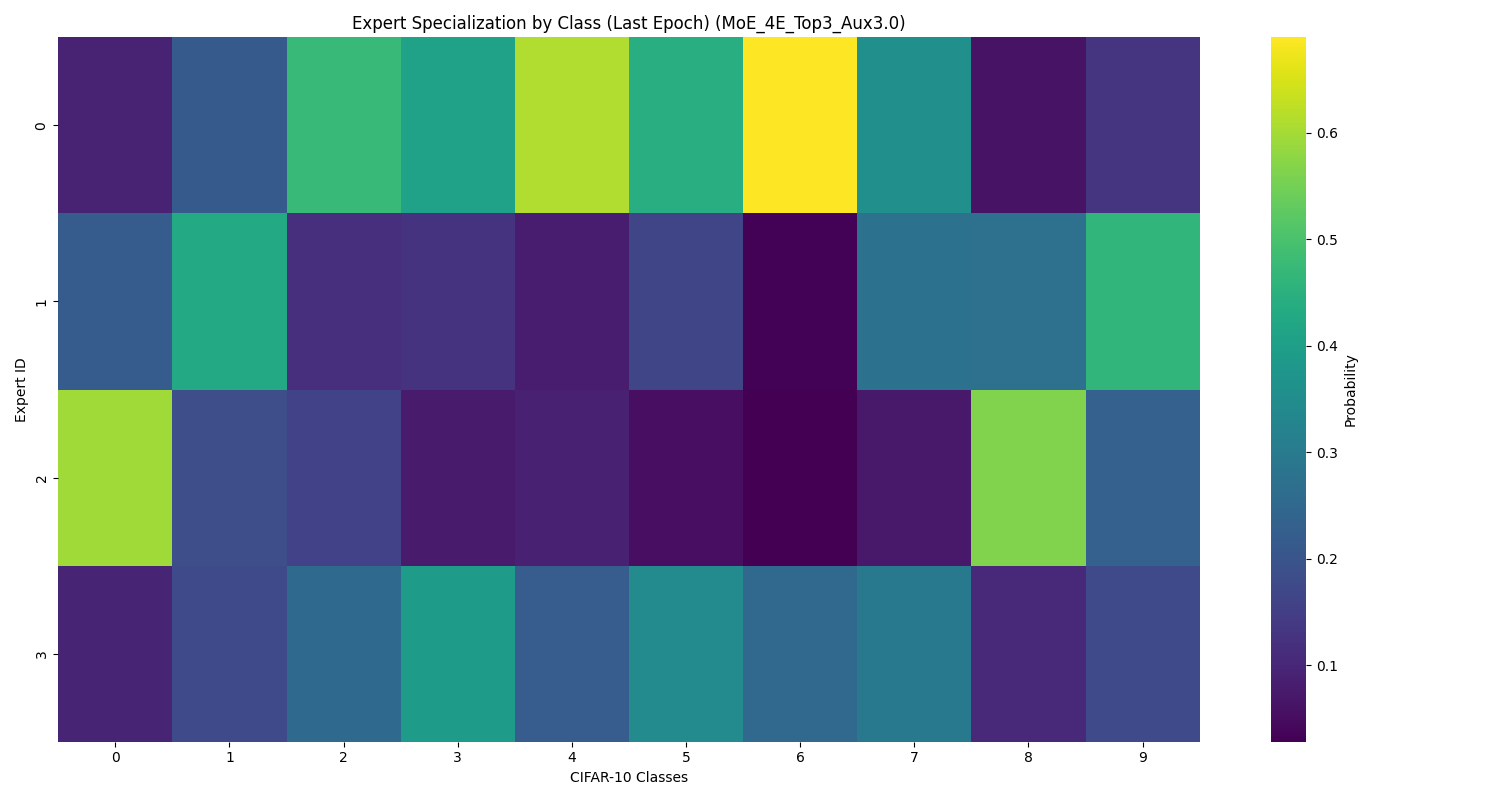


--- Specialization: MoE_8E_Top2_Aux10.0 ---


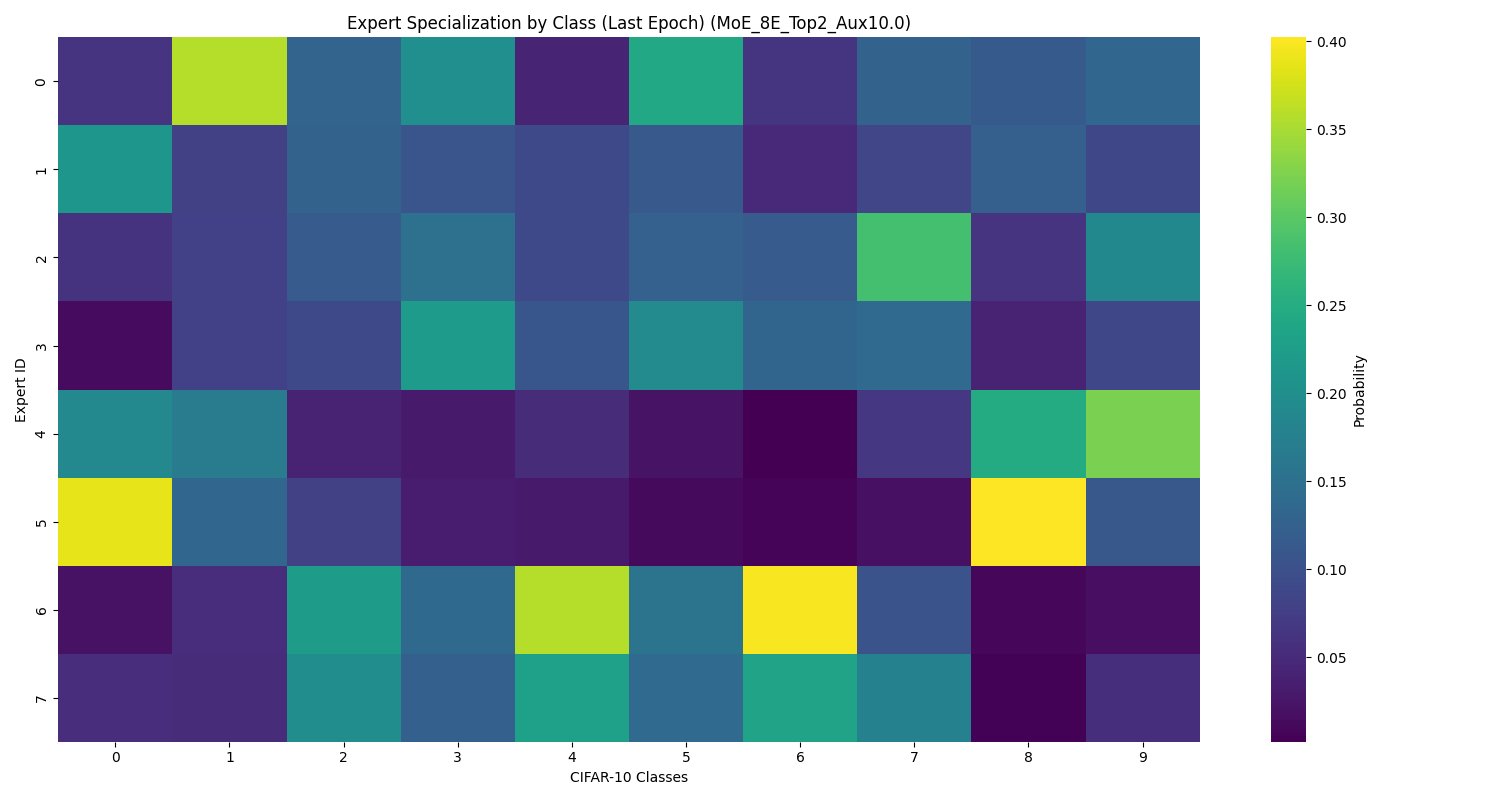

In [18]:
for name in moe_histories.keys():
    print(f"\n--- Specialization: {name} ---")
    hist = moe_histories[name]
    
    plot_expert_heatmap_from_history(hist, SAVE_DIR, title_suffix=f"({name})")
    display(Image(filename=os.path.join(SAVE_DIR, f'expert_specialization_heatmap{f"({name})".replace(" ", "_").lower()}.png')))


### Analysis of Specialization

The results confirm successful expert specialization. As illustrated by the confusion matrices, the gating network has learned to route specific classes to designated experts. We observe distinct patterns of activation, indicating that the MoE has effectively decomposed the problem space into expert-specific sub-tasks rather than maintaining a homogeneous distribution.